In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import gc

# this line forces theano to use the GPU and should go before importing cell2location
#os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=float32,force_device=True'
# if using the CPU uncomment this:
os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=float32,openmp=True,force_device=True'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

Global seed set to 0


# 导入单细胞reference数据集

In [2]:
## snRNA reference (raw counts)
adata_ref = anndata.read_h5ad("/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa2/anndata/reference.h5ad")

In [3]:
adata_ref

AnnData object with n_obs × n_vars = 3774 × 22141
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'group', 'time', 'RNA_snn_res.0.5', 'seurat_clusters', 'pANN_0.25_0.09_356', 'cellfilter', 'pANN_0.25_0.09_399', 'pANN_0.25_0.09_282', 'pANN_0.25_0.09_500', 'RNA_snn_res.0.6', 'celltype'
    var: 'gene_ids', 'feature_types'

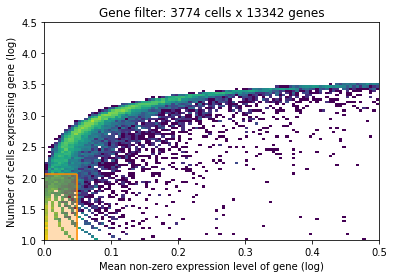

In [4]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [5]:
adata_ref

AnnData object with n_obs × n_vars = 3774 × 13342
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'group', 'time', 'RNA_snn_res.0.5', 'seurat_clusters', 'pANN_0.25_0.09_356', 'cellfilter', 'pANN_0.25_0.09_399', 'pANN_0.25_0.09_282', 'pANN_0.25_0.09_500', 'RNA_snn_res.0.6', 'celltype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'nonz_mean'

In [6]:
adata_ref.obs["batch"]=adata_ref.obs["group"]
adata_ref.obs["batch"]

E45_AAACCCAAGAGGGCGA-1    E45
E45_AAACCCAAGTGGCCTC-1    E45
E45_AAACCCAGTTTAAGGA-1    E45
E45_AAACGAAAGAGGGTGG-1    E45
E45_AAACGCTAGAAGGCTC-1    E45
                         ... 
E75_TTTCGATTCTGTGCGG-1    E75
E75_TTTGGAGAGTCAGCGA-1    E75
E75_TTTGGAGCACTCATAG-1    E75
E75_TTTGGAGGTATGAGGC-1    E75
E75_TTTGTTGCAGCATCTA-1    E75
Name: batch, Length: 3774, dtype: category
Categories (4, object): ['E45', 'E55', 'E65', 'E75']

In [7]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref, 
                        # 10X reaction / sample / batch
                        batch_key='batch', 
                        # cell type, covariate used for constructing signatures
                        labels_key='celltype', 
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        #categorical_covariate_keys=['Method']
                       )

In [8]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref) 

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'batch',
│   'labels_key': 'celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 3774  │
│          n_vars          │ 13342 │
│         n_batch          │   4   │
│         n_labels         │  10   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    E45     │          0          │
│                    │    E55     │          1          │
│                    │    E65     │          2          │
│                    │    E75     │          3          │
└────────────────────┴────────────┴─────────────────────┘

                   labels State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │   OSE_3    │          0          │
│                       │   OSE_5    │          1          │
│                       │   OSE_9    │          2          │
│                       │  PreGC_i0  │          3          │
│                       │  PreGC_i1  │          4          │
│                       │  PreGC_i2  │          5          │
│                       │  PreGC_i8  │          6          │
│                       │ PreGC_ii4  │          7          │
│                       │ PreGC_ii6  │          8          │
│                       │ PreGC_ii7  │          9          │
└───────────────────────┴────────────┴─────────────────────┘

In [9]:
mod.train(max_epochs=2000, use_gpu=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 2000/2000: 100%|██████████████| 2000/2000 [2:10:55<00:00,  3.93s/it, v_num=1, elbo_train=3.91e+7]


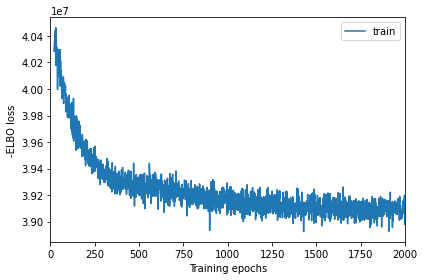

In [10]:
mod.plot_history(20)

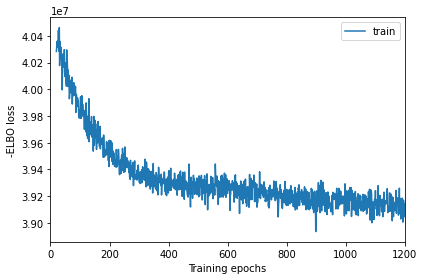

In [10]:
mod.plot_history(20)

In [11]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': False}
)

# Save model
mod.save("/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa2/anndata/reference_signatures", overwrite=True)

# Save anndata object with results
adata_file = "/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa2/anndata/reference_signatures/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [03:50<00:00,  4.33it/s]


'/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa2/anndata/reference_signatures/sc.h5ad'

In [9]:
## 后续导入
adata_file = "/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa2/anndata/reference_signatures/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load("/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa2/anndata/reference_signatures", adata_ref)

INFO     File /home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa2/anndata/referenc
         e_signatures/model.pt already downloaded                                            
INFO     Preparing underlying module for load                                                


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1/1000:   0%|                                      | 1/1000 [00:02<45:34,  2.74s/it, v_num=1, elbo_train=4.04e+7]


In [12]:
mod

RegressionBackgroundDetectionTech model with the following params: 
n_factors: 10 
n_batch: 4 
Training status: Trained

In [28]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,OSE_3,OSE_5,OSE_9,PreGC_i0,PreGC_i1
LOC100125545,0.134453,0.204539,0.082303,0.173557,0.122800
PSMB1,3.050674,3.373763,0.493585,3.535600,3.001476
FAM120B,0.143737,0.166518,0.124907,0.215697,0.198704
DLL1,0.047985,0.045733,0.017075,0.028677,0.021587
ERMARD,0.011615,0.019218,0.030242,0.057229,0.019105


### 我们来检查一下reference是否合适

In [29]:
inf_aver.index

Index(['LOC100125545', 'PSMB1', 'FAM120B', 'DLL1', 'ERMARD', 'PHF10',
       'C1H6orf120', 'WDR27', 'THBS2', 'FRMD1',
       ...
       'FGFBP1', 'CNGA1', 'MEPE', 'SOST', 'C13H7orf73', 'LOC106505818',
       'LOC110256688', 'WISP2', 'LOC102159694', 'SCGB1A1'],
      dtype='object', length=13342)

## 接下来要读入空转数据

In [2]:
## 设置工作目录
# Set paths to data and results used through the document:
sp_data_folder = '/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa2/'
results_folder = '/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa2/results/'

#regression_model_output = 'RegressionGeneBackgroundCoverageTorch_65covariates_40532cells_12819genes'
#reg_path = f'{results_folder}regression_model/{regression_model_output}/'

In [3]:
def read_and_qc(sample_name, path=sp_data_folder + 'data/Visum_data/'):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.
    
    :param sample_name: Name of the sample
    :param path: path to data
    """
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

In [4]:
# Read the list of spatial experiments
sample_data = pd.read_csv(sp_data_folder + 'Visium_mouse.csv')
sample_data

,sample_name,sample_name2,image_name,slide,position
0,E45,Visium-E45,E45.jpg,V10N30-114,A1
1,E55,Visium-E55,E55.jpg,V10N30-114,B1
2,E65,Visium-E65,E65.jpg,V10N30-114,C1
3,E75,Visium-E75,E75.jpg,V10N30-114,D1


In [5]:
# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path=sp_data_folder + 'data/Visum_data/'))

In [6]:
## 合并所有文件
# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)
#######################

In [7]:
adata

AnnData object with n_obs × n_vars = 6728 × 27352
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-E45', 'mean_counts-E45', 'log1p_mean_counts-E45', 'pct_dropout_by_counts-E45', 'total_counts-E45', 'log1p_total_counts-E45', 'n_cells_by_counts-E55', 'mean_counts-E55', 'log1p_mean_counts-E55', 'pct_dropout_by_counts-E55', 'total_counts-E55', 'log1p_total_counts-E55', 'n_cells_by_counts-E65', 'mean_counts-E65', 'log1p_mean_counts-E65', 'pct_dropout_by_counts-E65', 'total_counts-E65', 'log1p_total_counts-E65', 'n_cells_by_counts-E75', 'mean_counts-E75', 'log1p_mean_counts-E75', 'pct_dropout_by_counts-E75', 'total_counts-E75', 'log1p_total_counts-E75'
    uns: 'spatial'
    obsm: 'spatial'

In [8]:
# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
adata = adata[:, ~adata.var['mt'].values]

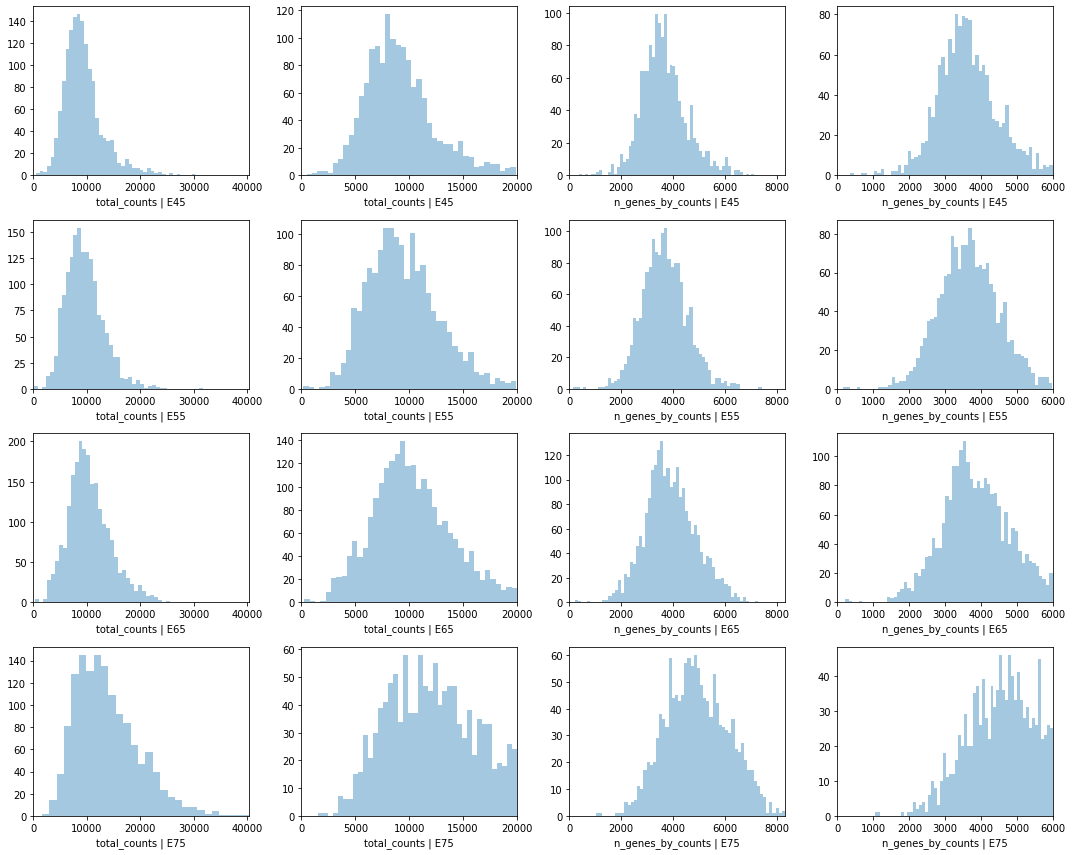

In [9]:
# 质控步骤
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    slide = select_slide(adata, s)
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

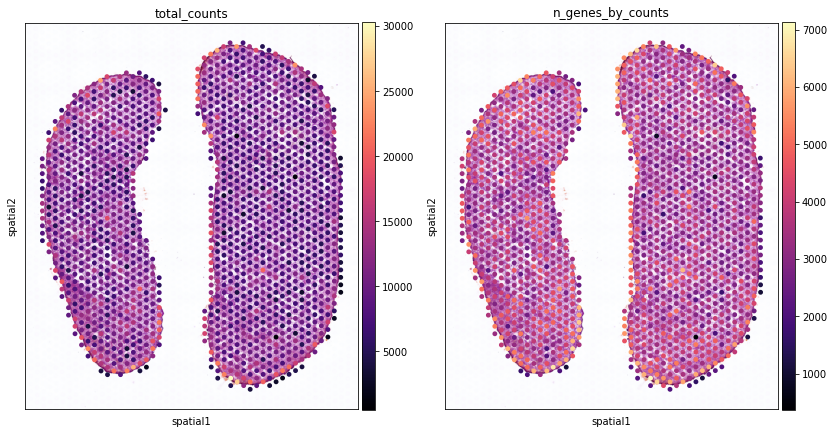

In [10]:
slide = select_slide(adata, 'E45')

with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'white'}):
    sc.pl.spatial(slide, img_key = "hires", cmap='magma', 
                  library_id=list(slide.uns['spatial'].keys())[0],
                  color=['total_counts', 'n_genes_by_counts'], size=1,
                  gene_symbols='SYMBOL', show=False, return_fig=True)

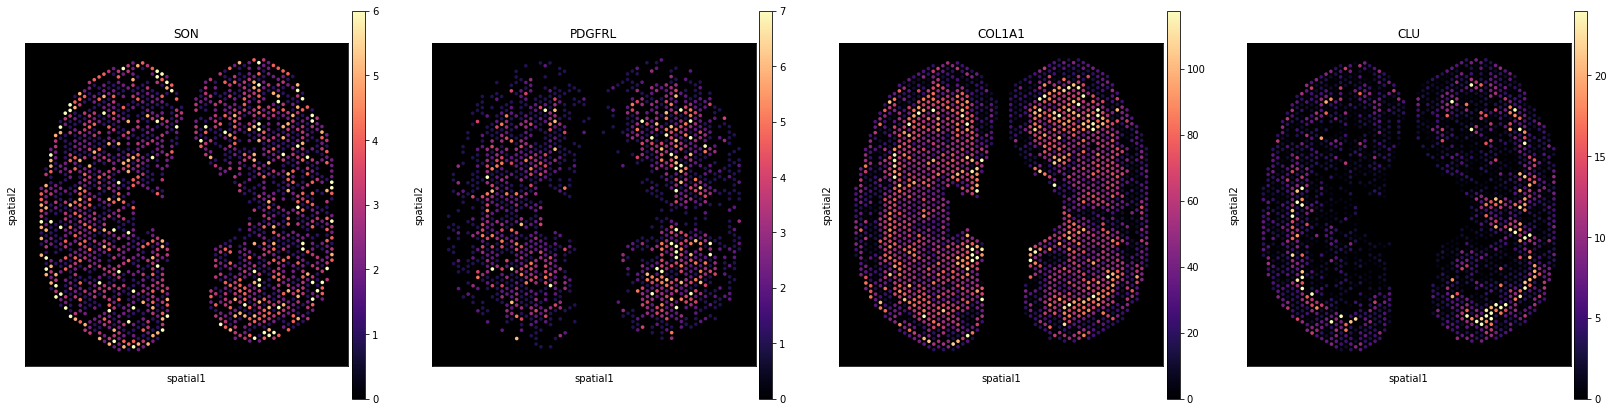

In [20]:
## slide = select_slide(adata, 'E75')  检查表达量
slide = select_slide(adata, 'E65')
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(slide, 
                  color=["SON", "PDGFRL","COL1A1","CLU"], img_key=None, size=1,
                  vmin=0, cmap='magma', vmax='p99.0',
                  gene_symbols='SYMBOL'
                 )
# 中间 OSR1
# 第三层： HES4
#  最外侧： KRT19

In [40]:
## Add counts matrix
adata_vis = adata.copy()
adata_vis.raw = adata_vis

## Cell2location: spatial mapping
## 正式开始deconvolution之前，先检查一下reference数据以及visum数据

In [41]:
adata_vis.var_names

Index(['LOC100125545', 'TBP', 'PSMB1', 'FAM120B', 'DLL1', 'LOC110259813',
       'LOC110259814', 'LOC106508781', 'LOC110259815', 'LOC110259816',
       ...
       'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3', 'ND4L', 'ND4', 'ND5', 'ND6',
       'CYTB'],
      dtype='object', name='ENSEMBL', length=27352)

In [42]:
inf_aver.index

Index(['LOC100125545', 'PSMB1', 'FAM120B', 'DLL1', 'ERMARD', 'PHF10',
       'C1H6orf120', 'WDR27', 'THBS2', 'FRMD1',
       ...
       'FGFBP1', 'CNGA1', 'MEPE', 'SOST', 'C13H7orf73', 'LOC106505818',
       'LOC110256688', 'WISP2', 'LOC102159694', 'SCGB1A1'],
      dtype='object', length=13342)

In [43]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [44]:
adata_vis

AnnData object with n_obs × n_vars = 6728 × 13326
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-E45', 'mean_counts-E45', 'log1p_mean_counts-E45', 'pct_dropout_by_counts-E45', 'total_counts-E45', 'log1p_total_counts-E45', 'n_cells_by_counts-E55', 'mean_counts-E55', 'log1p_mean_counts-E55', 'pct_dropout_by_counts-E55', 'total_counts-E55', 'log1p_total_counts-E55', 'n_cells_by_counts-E65', 'mean_counts-E65', 'log1p_mean_counts-E65', 'pct_dropout_by_counts-E65', 'total_counts-E65', 'log1p_total_counts-E65', 'n_cells_by_counts-E75', 'mean_counts-E75', 'log1p_mean_counts-E75', 'pct_dropout_by_counts-E75', 'total_counts-E75', 'log1p_total_counts-E75'
   

## 下一步需要选择超参数，这里先试用默认参数

In [45]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=22, ## 根据自己数据进行调整
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=10, #s
    detection_mean_per_sample=True
) 
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 6728  │
│          n_vars          │ 13326 │
│         n_batch          │   4   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    E45     │          0          │
│                     │    E55     │          1          │
│                     │    E65     │          2          │
│                     │    E75     │          3          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 15000/15000: 100%|██████████| 15000/15000 [36:38:30<00:00,  8.79s/it, v_num=1, elbo_train=6.6e+7]


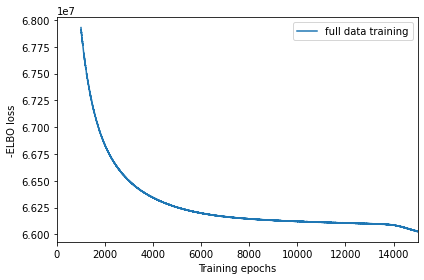

In [46]:
## 2022.8.14.10:32开始 
mod.train(max_epochs=15000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [48]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

# Save model
mod.save("/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa2/results/cell2location_map", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = "/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa2/results/cell2location_map/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|████████████████| 999/999 [15:28<00:00,  1.08it/s]


'/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa2/results/cell2location_map/sp.h5ad'

In [26]:
adata_file = "/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa/results/cell2location_map/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load("/home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa/results/cell2location_map/", adata_vis)

INFO     File /home/lab401_B/10xSpatial/cell2location/Spatial_pig_granulosa/results/cell2loca
         tion_map/model.pt already downloaded                                                
INFO     Preparing underlying module for load                                                


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1/30000:   0%|                                 | 1/30000 [00:06<52:04:18,  6.25s/it, v_num=1, elbo_train=8.43e+7]


In [27]:
# 直接读入之后，下面QC一直报错，我查看了一下，加上了这步
# 报错： self.samples is missing, please run self.export_posterior() first
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

Sampling global variables, sample: 100%|█████████████████████████████████████████████| 999/999 [12:02<00:00,  1.38it/s]


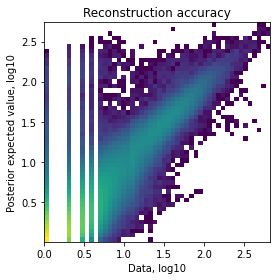

In [49]:
mod.plot_QC()

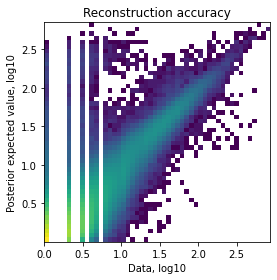

In [28]:
mod.plot_QC()

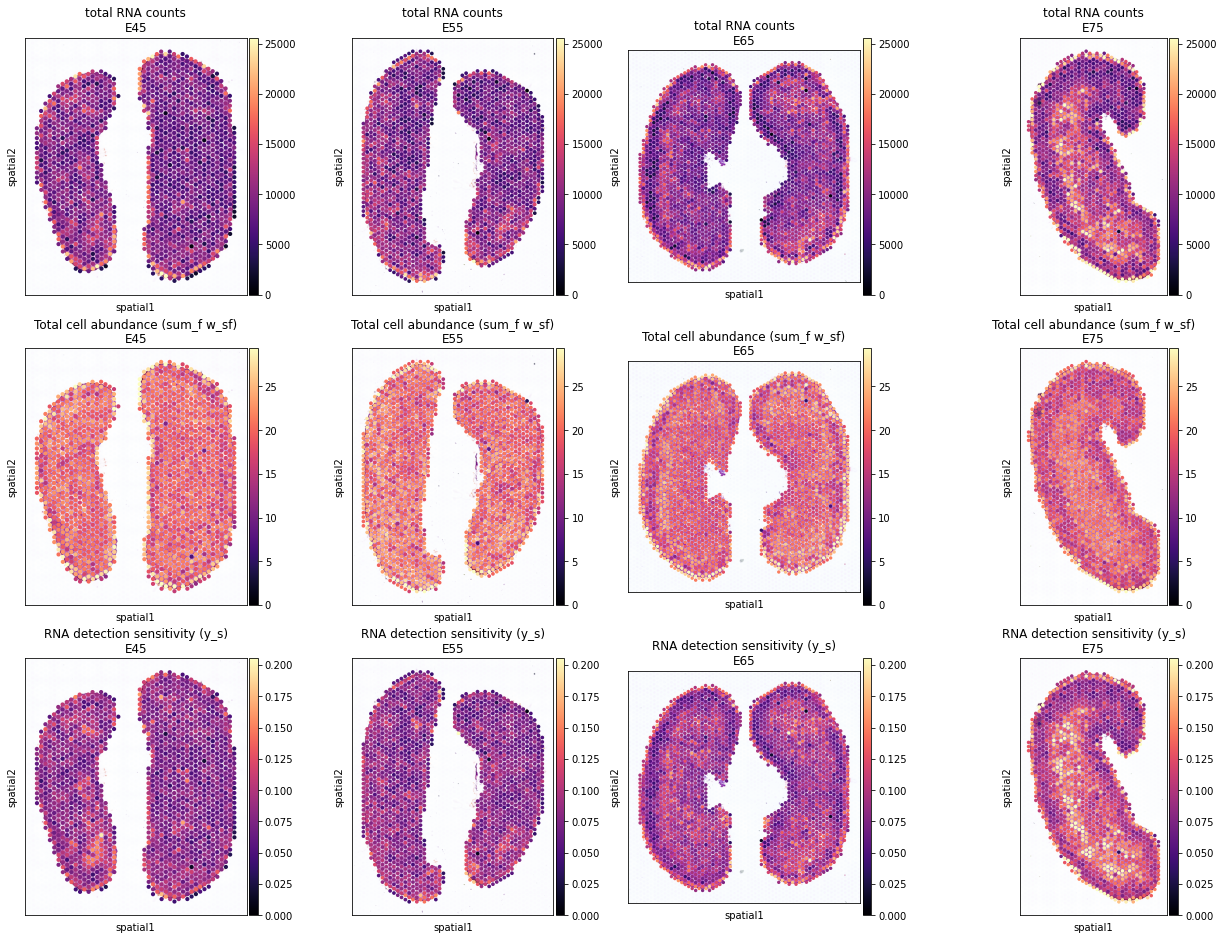

In [50]:
fig = mod.plot_spatial_QC_across_batches()

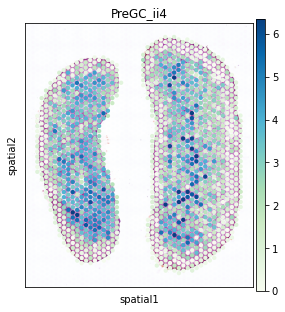

In [80]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'E45')
    
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    
    sc.pl.spatial(slide, cmap='GnBu',
                  # show first 8 cell types
                  color=["PreGC_ii4"], 
                  ncols=4, size=1.3, 
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2',
                  save="PreGC_ii4_E45.pdf"
                 )
    
# OSE: OSE9    # BuPu
# PreGC_ii4    # GnBu
# PreGC_i1     # RdPu

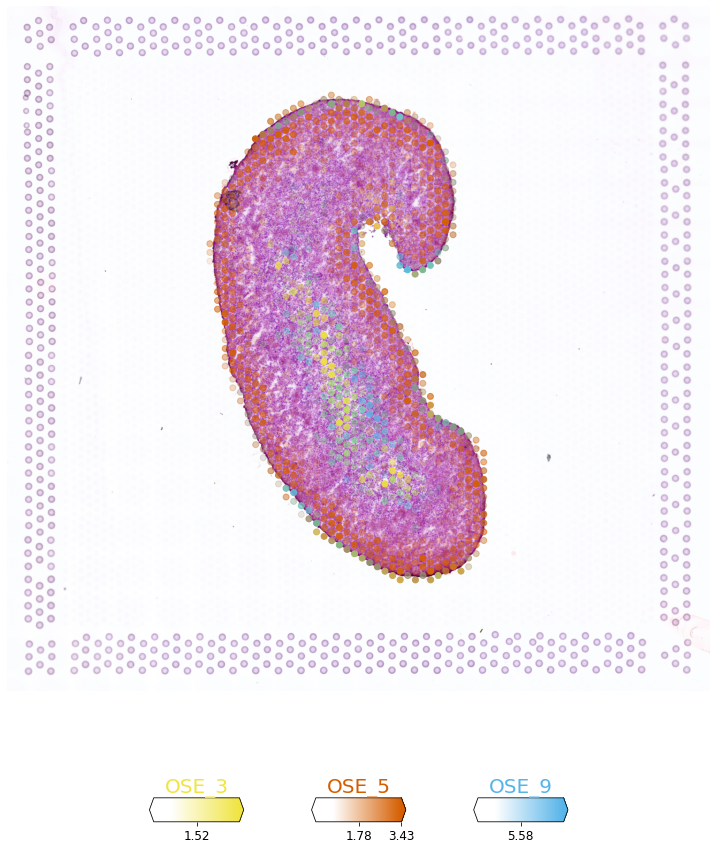

In [42]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters 
clust_labels = ['OSE_3', 'OSE_5',"OSE_9"]
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'E75')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide, 
        # labels to show on a plot
        color=clust_col, labels=clust_labels, 
        show_img=True,
        # alpha_scaling=1,
        # 'fast' (white background) or 'dark_background'
        style='fast', 
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6, 
        reorder_cmap=range(0, 7),
        colorbar_position='bottom',
        adjust_text = True
       # image_cmap='Greys_r'
    )
#fig.savefig('A.pdf', format='pdf')
#plt.savefig(fname="./figures/E45_Germ_dpi600_celltype.pdf",dpi=600, format="pdf")